# Part 2 - House prices

Data cleaning
---
Your analysis should include the necessary data cleaning steps. For instance

- Find and handle incorrect, missing values
- Correct inconsistencies in the variables
- Handle outliers

You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create an missing category. In any case, justify your choices!

In [6]:
# import libraries 
%matplotlib inline
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import re

In [4]:
# load data train/test 
train_df = pd.read_csv("house-prices.csv")
test_df = pd.read_csv("house-prices-test.csv")

# Display the first 5 rows of data train
train_df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    484  528275070           60        RL           NaN      8795   Pave   
1   2586  535305120           20        RL          75.0     10170   Pave   
2   2289  923228250          160        RM          21.0      2001   Pave   
3    142  535152150           20        RL          70.0     10552   Pave   
4   2042  903475060          190        RM          60.0     10120   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
2   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
3   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Bnk  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       4    2009       WD           Normal     236000  
1        0       6    2006       WD           Normal     155000  
2        0       1    2007       WD           Normal      75000  
3        0       4    2010       WD           Normal     165500  
4        0       1    2007       WD           Normal     122000  

[5 rows x 82 columns]

You can find a detailed description of each variable in the ``documentation.txt file``, but there are a few things to know.

- The ``Order`` and ``PID`` variables are identifiers. They are not useful to predict house prices.
- The variables are not necessarily encoded consistently. For instance, ``MS SubClass`` (the type of dwelling) and ``MS Zoning`` (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.
- The data isn’t clean: there are incorrect and missing values, outliers and inconsistencies

You should address all these issues during the data cleaning stage.

In [7]:
def find_col_types(text):
    types = ["Nominal", "Ordinal", "Discrete",]
    pattern = r"(.*)\((Nominal|Ordinal|Discrete|Continuous)\):"
    matches = re.findall(pattern, text)
    return {col.strip(): typ.strip() for col, typ in matches}


with open('documentation.txt', 'r',  encoding='ISO-8859-1') as file:
    text = file.read()
    types = find_col_types(text)


In [8]:
col_normal = []

col_ordinal = []

col_discrete = []

col_continous = []


for col in types:
    value = types.get(col)
    if value == "Nominal":
        col_normal.append(col)
    elif value == "Ordinal":
        col_ordinal.append(col)
    elif value == "Discrete":
        col_discrete.append(col)
    else:
        col_continous.append(col)

# Remove columne not find in the data
# for Nominal columns
items_remove = ['Exterior 1', 'Exterior 2']
for i in items_remove:
    col_normal.remove(i) 

# For Ordinal colums
items_remove2 = ['BsmtFinType 2', 'HeatingQC', 'KitchenQual', 'FireplaceQu']
for i in items_remove2:
    col_ordinal.remove(i) 

# For Discrete columns
items_remove3 = ['Bedroom', 'Kitchen', 'TotRmsAbvGrd']
for i in items_remove3:
    col_discrete.remove(i)

# For Continous colums
col_continous.remove('3-Ssn Porch')


print("Nominal columns", len(col_normal))
print("Ordinal columns", len(col_ordinal))
print("Discrete columns", len(col_discrete))
print("Continous columns", len(col_continous))

Nominal columns 22
Ordinal columns 18
Discrete columns 12
Continous columns 18


In [9]:
len(col_normal) + len(col_ordinal) + len(col_discrete) + len(col_continous)

70

# plot to check

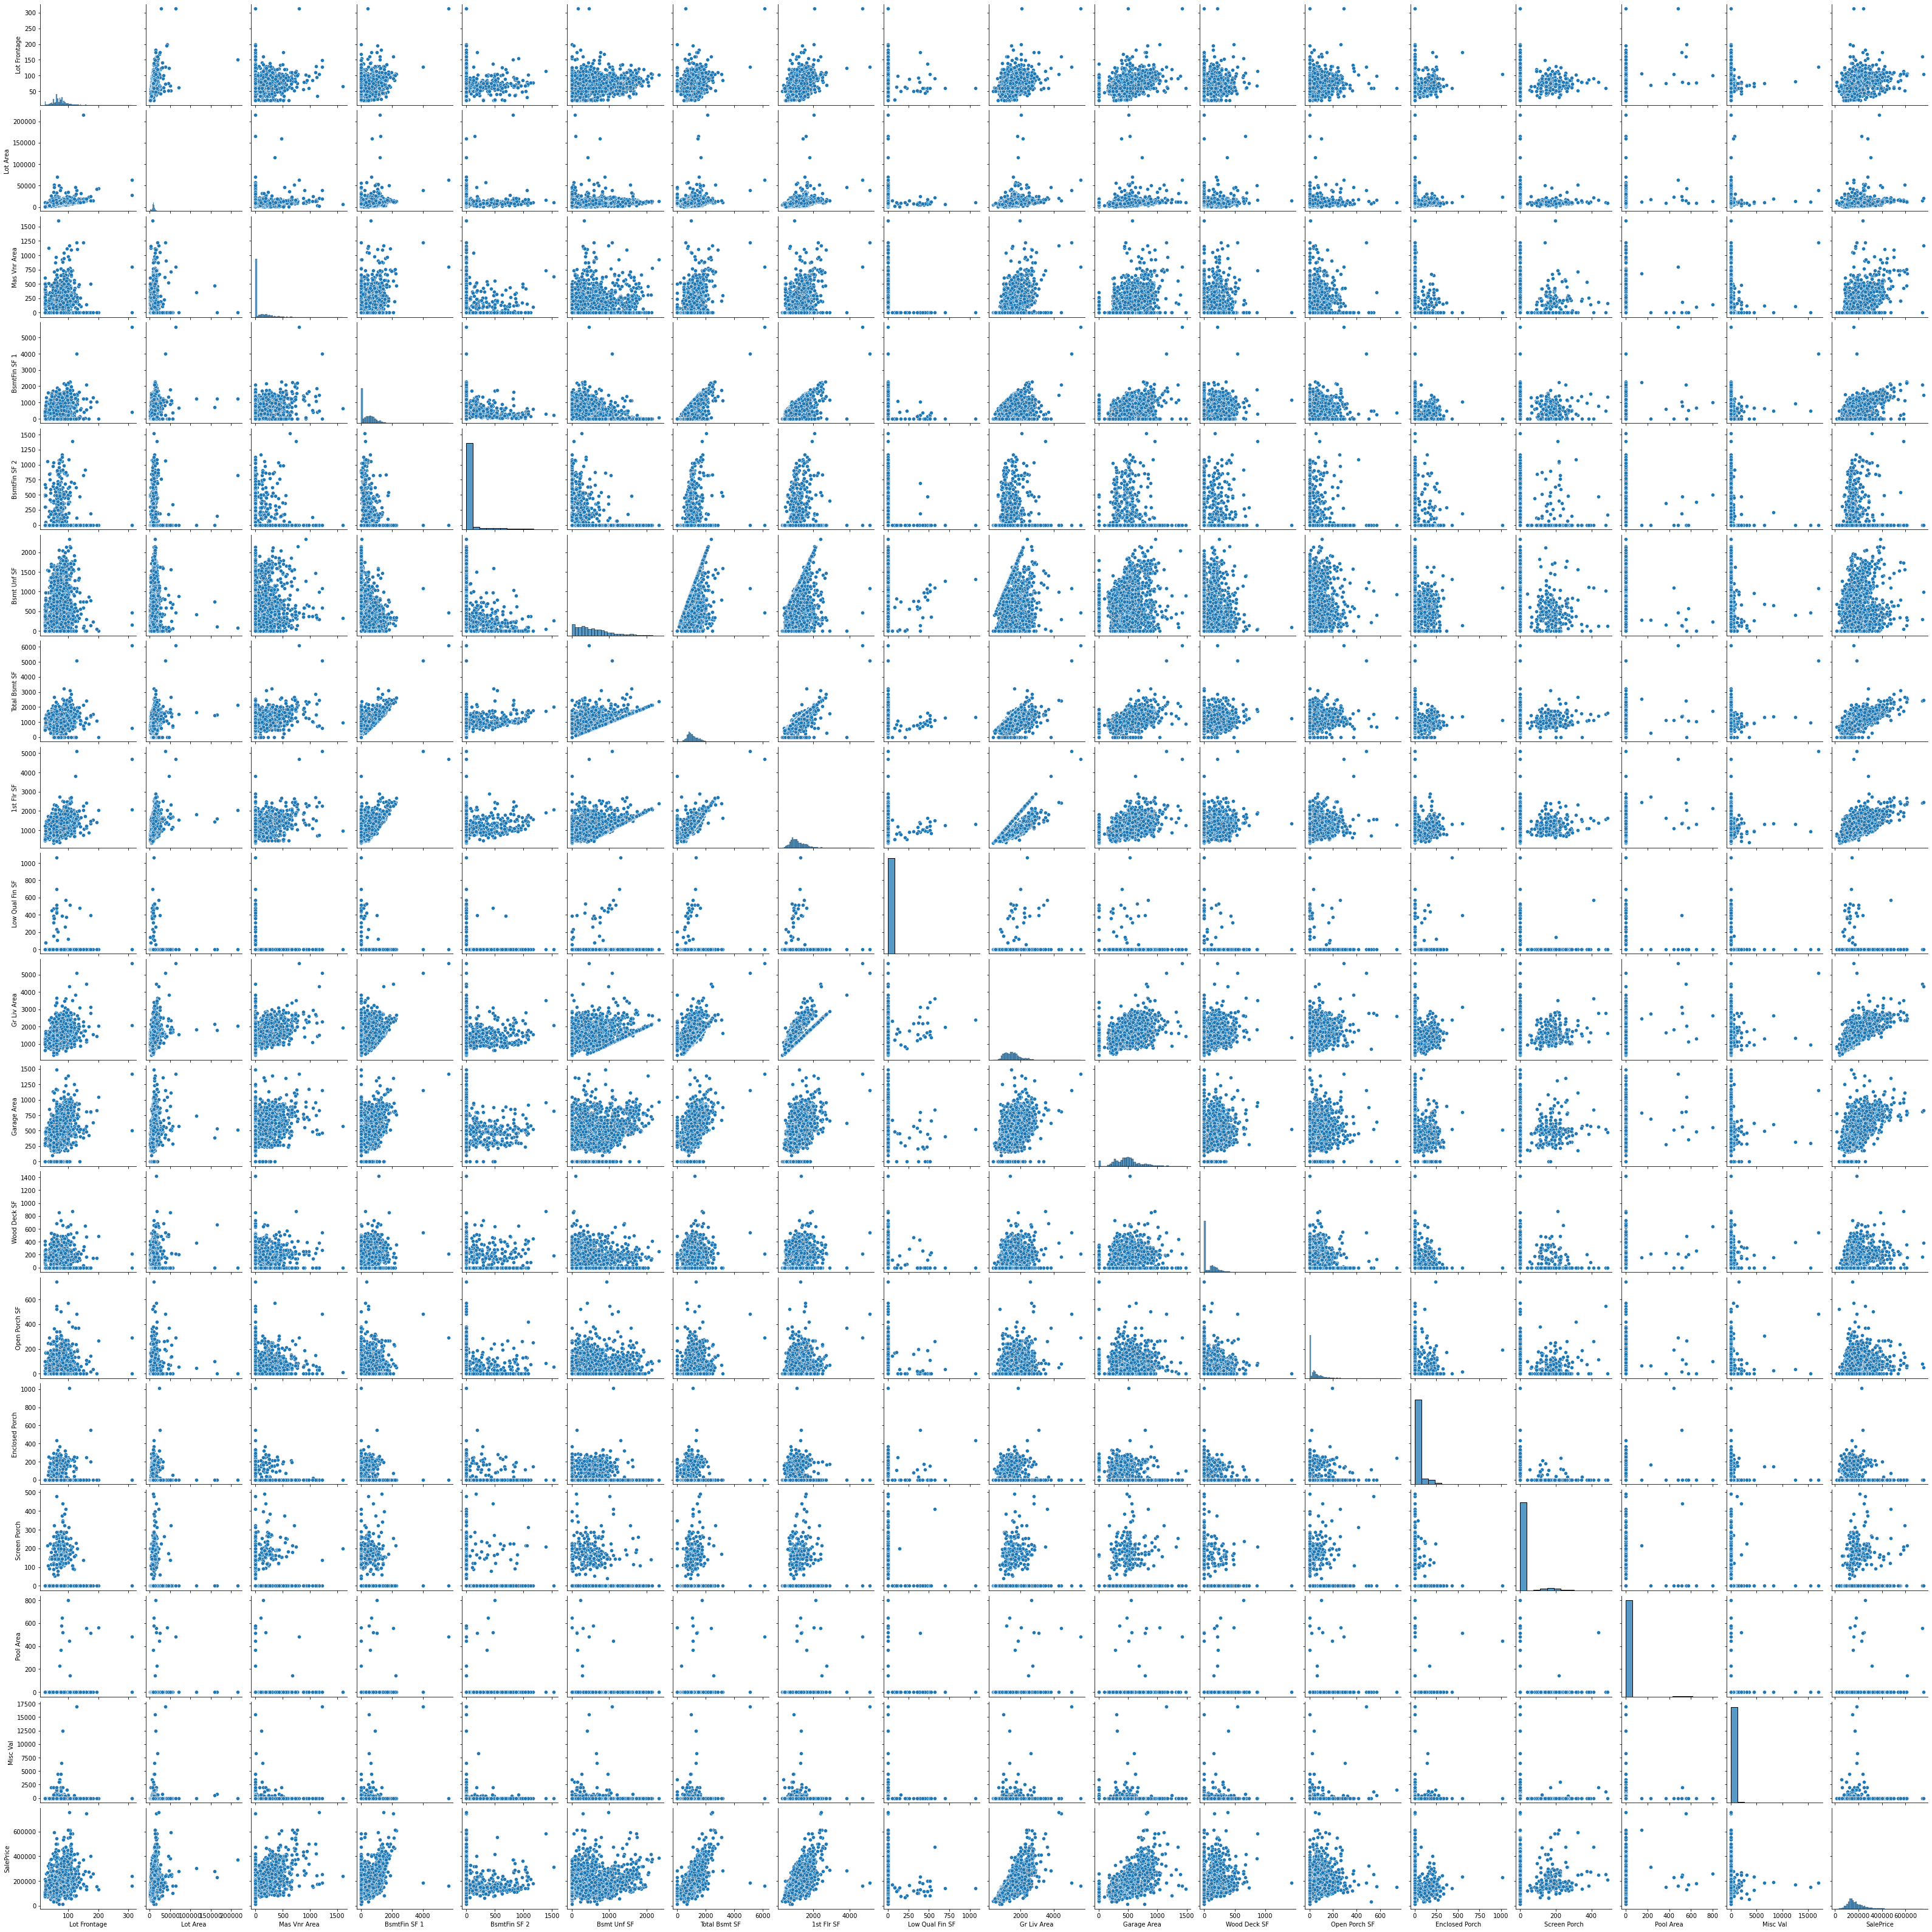

In [13]:
sns.pairplot(train_df[col_continous])

In [ ]:
# Drop Order and PID variable 
train_df = train_df.drop(["Order", "PID"], axis=1)

In [ ]:
# Check for duplicated values
train_df.duplicated().sum()

0

In [ ]:
# Number of NaN values
train_df.isna().sum().sum()

11670

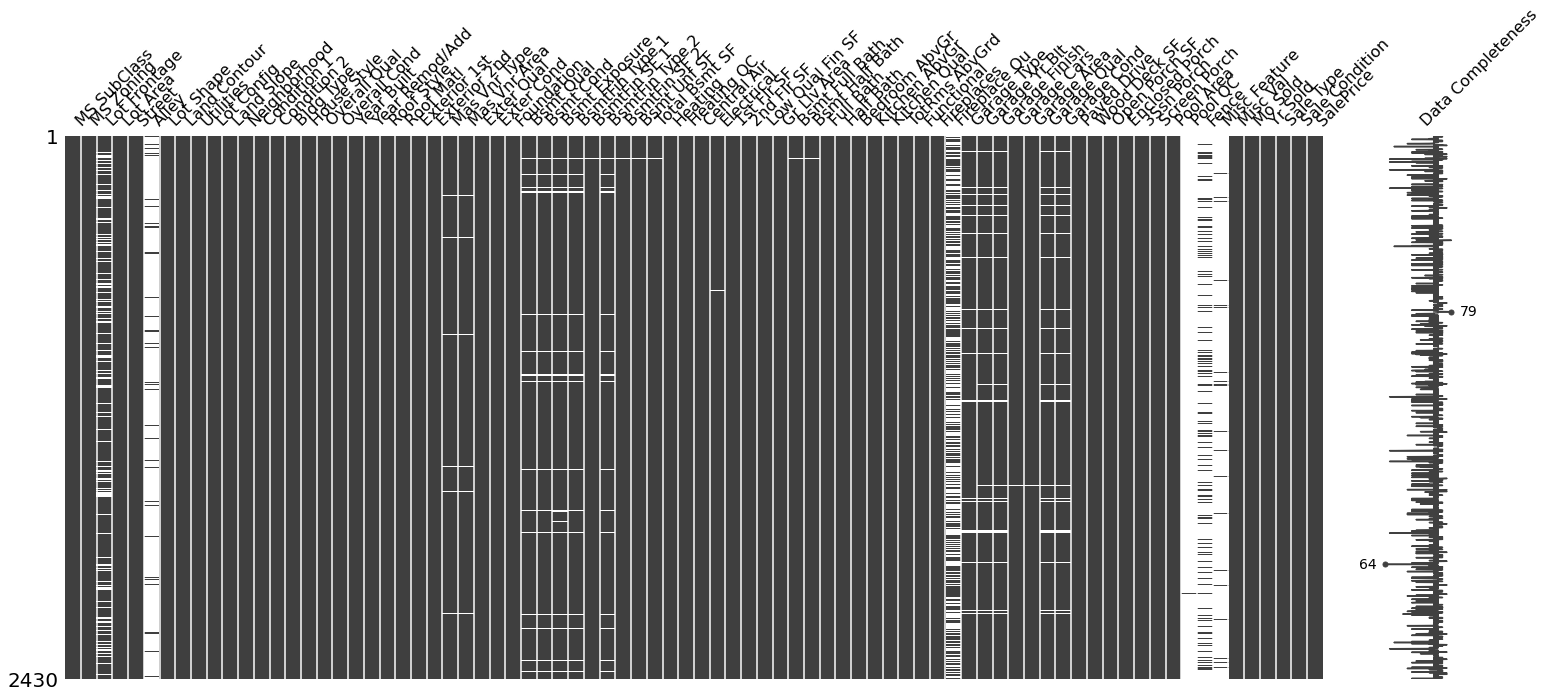

In [ ]:
import missingno as msno
# Using msno.matrix() to see more details
msno.matrix(train_df, labels=True);

I will set all string values (object) that containes NaN values to "missing" and 0 for numerical values to avoid dropping 2430 rows or replacing missing values by the median or they average that could impact the accuracy of the prediction.  


In [ ]:
# Fill NaN by missing fot object 
train_df[train_df.select_dtypes(exclude="number").columns] = train_df[train_df.select_dtypes(exclude="number").columns].fillna("missing")
# Fill NaN by 0 for numerical values
train_df[train_df.select_dtypes(include="number").columns] = train_df[train_df.select_dtypes(include="number").columns].fillna(0)

- The variables are not necessarily encoded consistently. For instance, MS SubClass (the type of dwelling) and MS Zoning (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.

Change MS SubClass type to ``str`` to enable the function ``pd.get_dummies`` to work in this categorical variable.

In [ ]:
""" to check """
# Change MS SubClass type to str 
train_df["MS SubClass"] = train_df["MS SubClass"].astype(str)

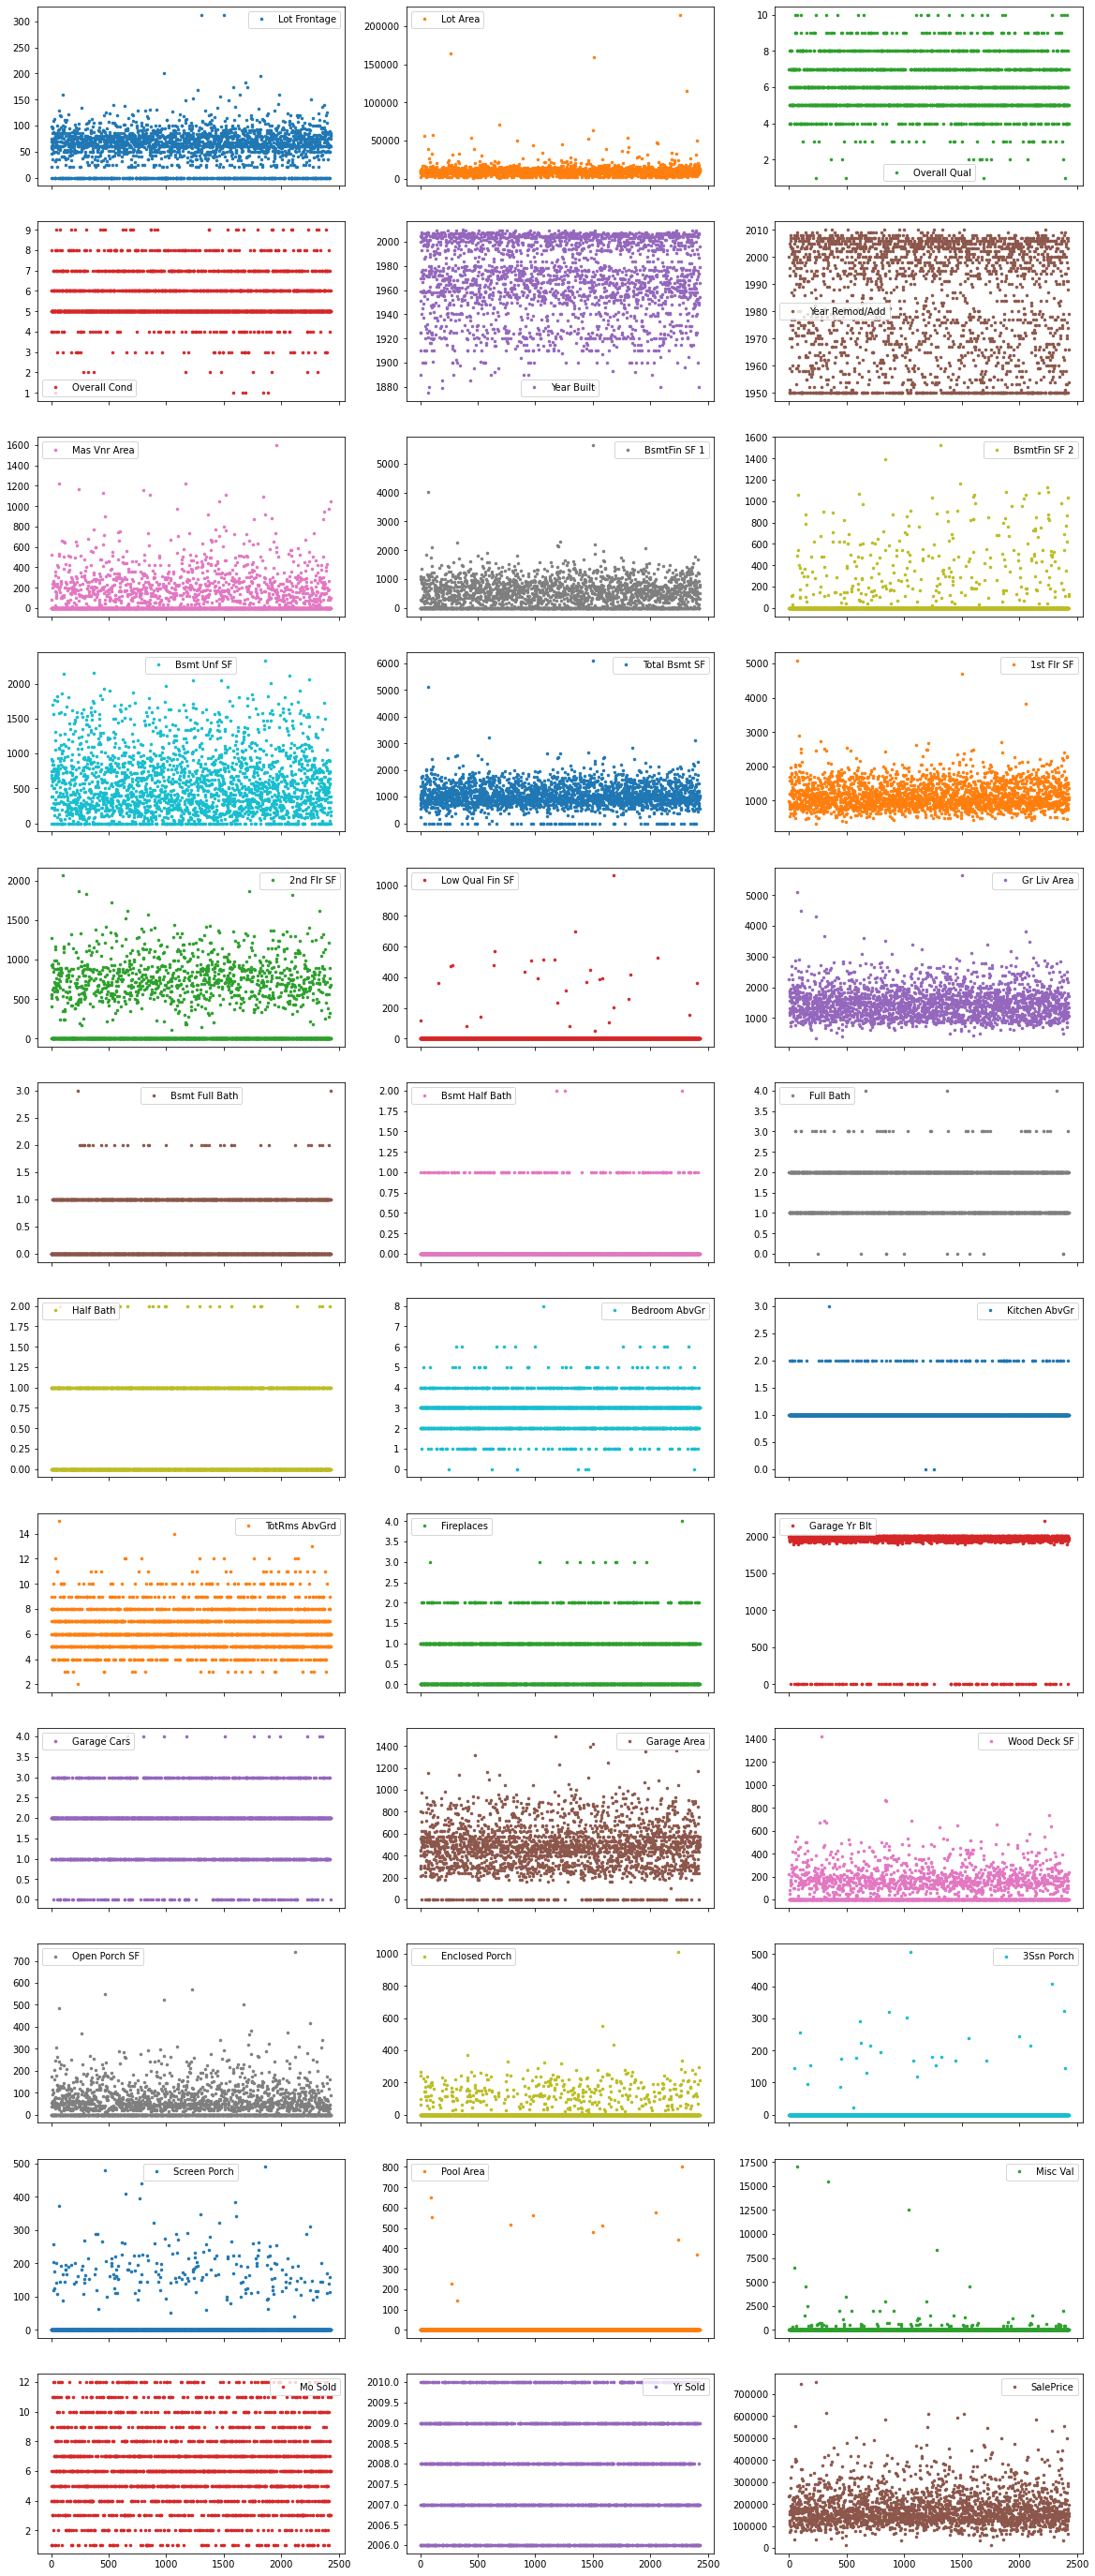

In [ ]:
# Plot all numerical values to check outliers
train_df.plot(
    subplots=True,
    marker=".",
    lw=0, 
    layout=(-1, 3),
    figsize=(20, 50),
    markersize=5,

);


Remove outlier according to the range set

In [ ]:
# Set range 
range_values = {
    "Lot Frontage": [200, 320],
    "Lot Area": [100000, 220000],
    "BsmtFin SF 1": [3000, 6000],
    "Enclosed Porch" : [600, 1200],
    "Wood Deck SF" : [1200, 1500]
} 

# Remove outlier according to the range set
for col in range_values:
    # Get range numbers
    num = range_values.get(col)
    # locate values that are in the range
    mask = train_df[col].between(num[0], num[1])
    # Drop values outide the sepecified range
    """ to remove!!!! """
    print(mask.loc[mask].shape) 
    train_df = train_df.drop(mask.loc[mask].index)
 

print("New tarin_df without outliers shape:", train_df.shape)


(3,)
(4,)
(1,)
(1,)
(1,)
New tarin_df without outliers shape: (2420, 82)


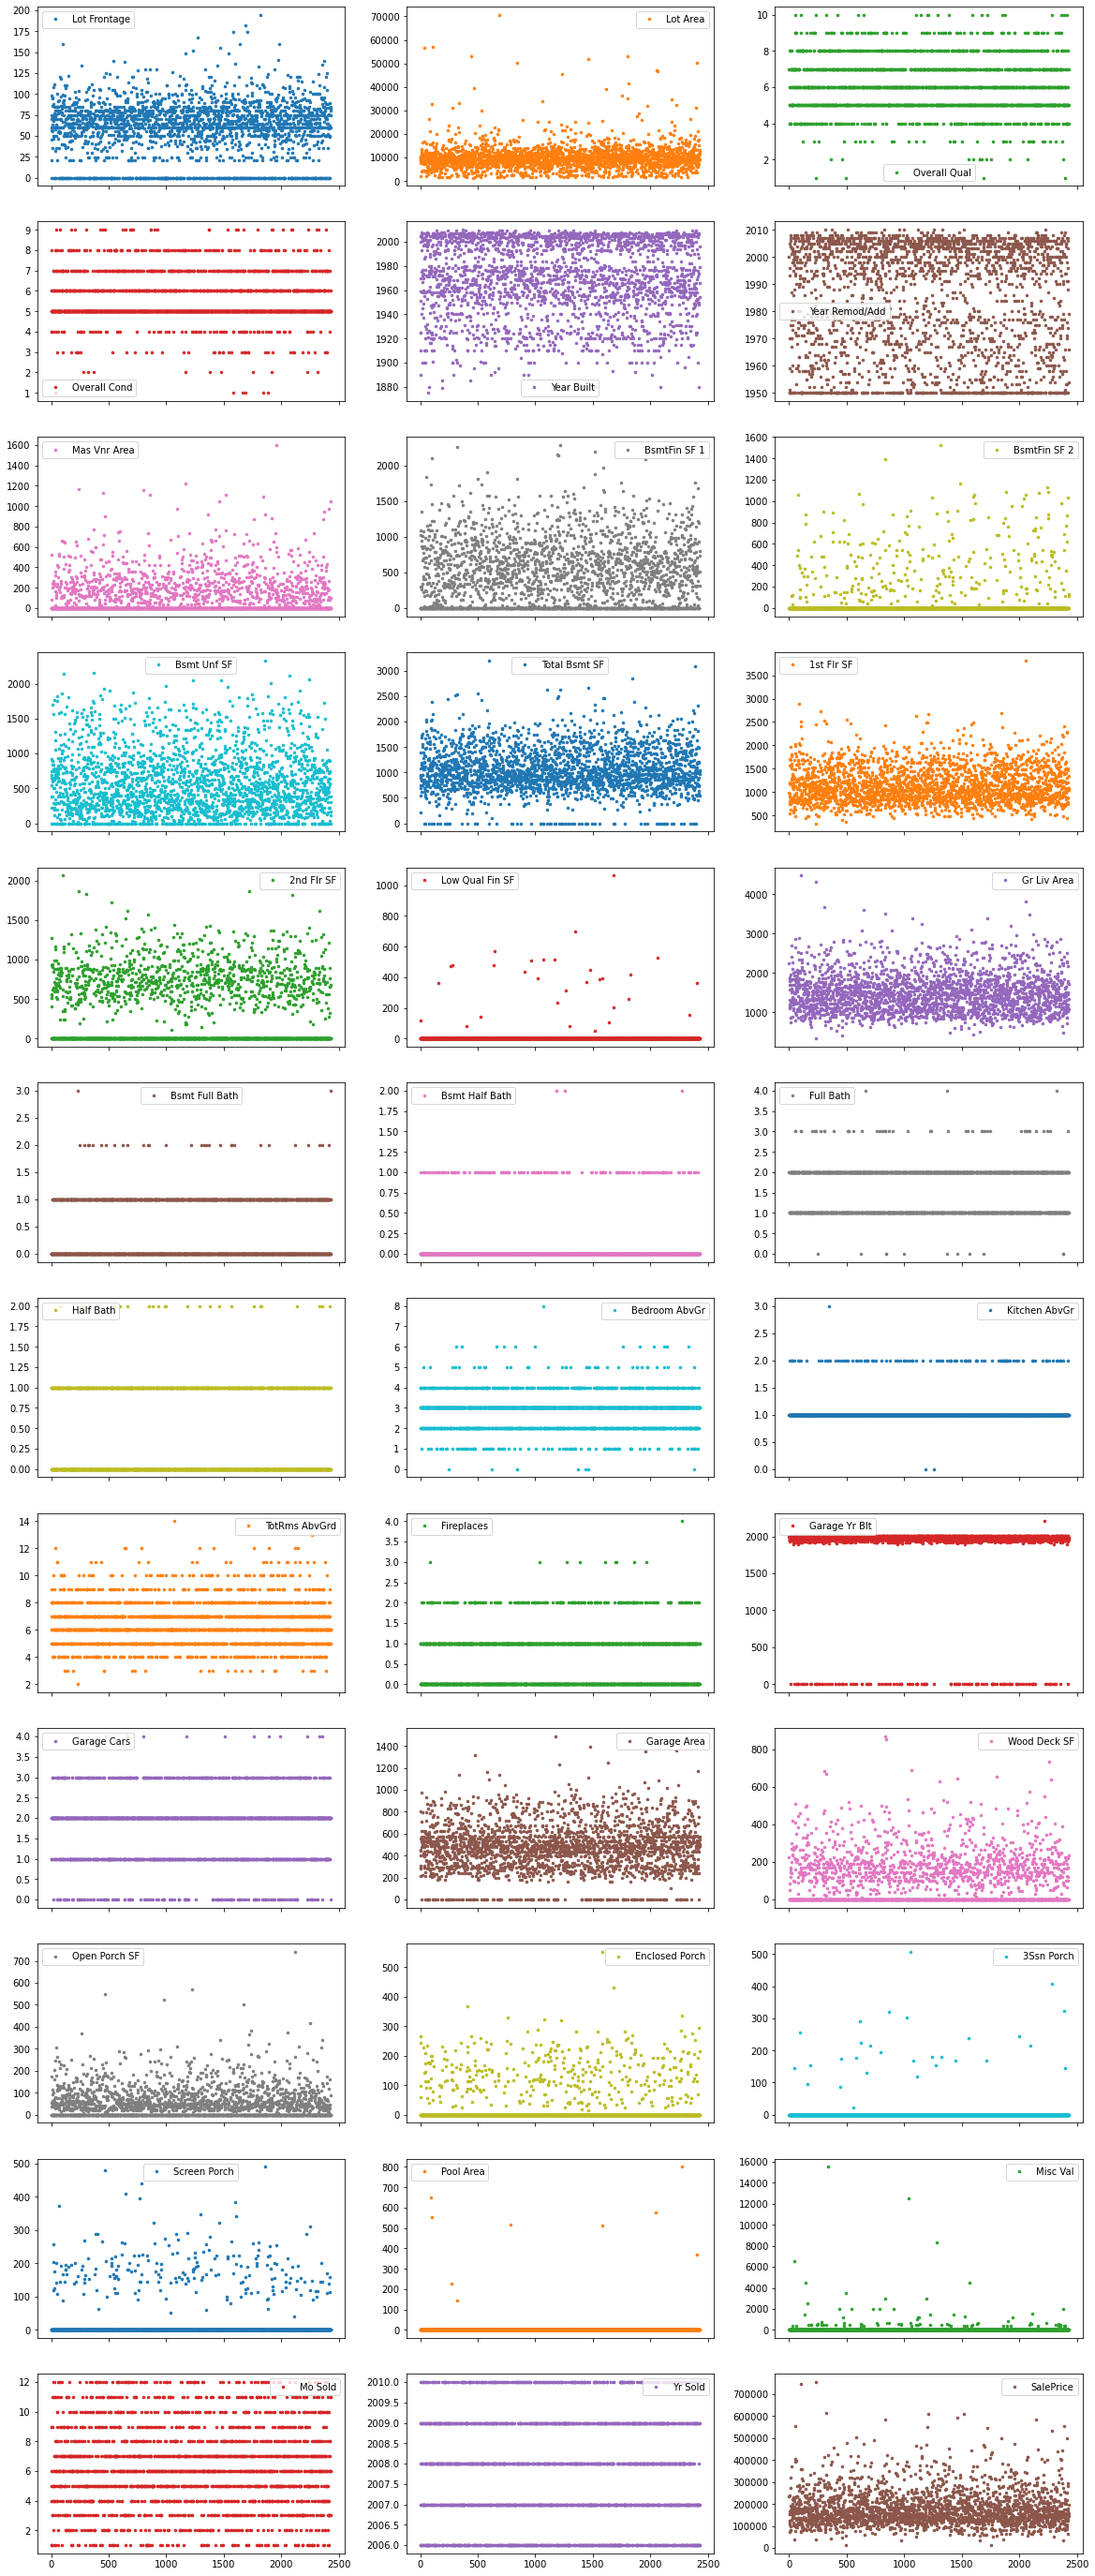

In [ ]:
# Plot all numerical values to check outliers
train_df.plot(
    subplots=True,
    marker=".",
    lw=0, 
    layout=(-1, 3),
    figsize=(20, 50),
    markersize=5,

);


Correcting inconsistencies in the variables by convert all the strings in a column to lowercase using the ``"str.lower()`` method:

In [ ]:
""" To check probably not necessary """
# Convert all string to lowercase
str_features = train_df.select_dtypes(exclude="number").columns

for col in str_features:
    train_df[col] = train_df[col].str.lower()

# Dispaly the change
train_df.select_dtypes(exclude="number").head()

MS Zoning Street Alley Lot Shape Land Contour Utilities Lot Config  \
0        rl   pave   NaN       ir1          lvl    allpub     inside   
1        rl   pave   NaN       reg          lvl    allpub     corner   
2        rm   pave   NaN       reg          lvl    allpub     inside   
3        rl   pave   NaN       ir1          lvl    allpub     inside   
4        rm   pave   NaN       ir1          bnk    allpub     inside   

  Land Slope Neighborhood Condition 1  ... Garage Type Garage Finish  \
0        gtl      gilbert        norm  ...     builtin           fin   
1        gtl        names        norm  ...      attchd           unf   
2        gtl      meadowv        norm  ...      attchd           unf   
3        gtl        names        norm  ...      attchd           rfn   
4        gtl      oldtown       feedr  ...      detchd           unf   

  Garage Qual Garage Cond Paved Drive Pool QC  Fence Misc Feature Sale Type  \
0          ta          ta           y     NaN    NaN          NaN       wd    
1          ta          ta           y     NaN    NaN          NaN       wd    
2          ta          ta           y     NaN    NaN          NaN       wd    
3          ta          ta           y     NaN    NaN          NaN       wd    
4          ta          ta           n     NaN  mnprv          NaN       wd    

  Sale Condition  
0         normal  
1         normal  
2         normal  
3         normal  
4         normal  

[5 rows x 43 columns]

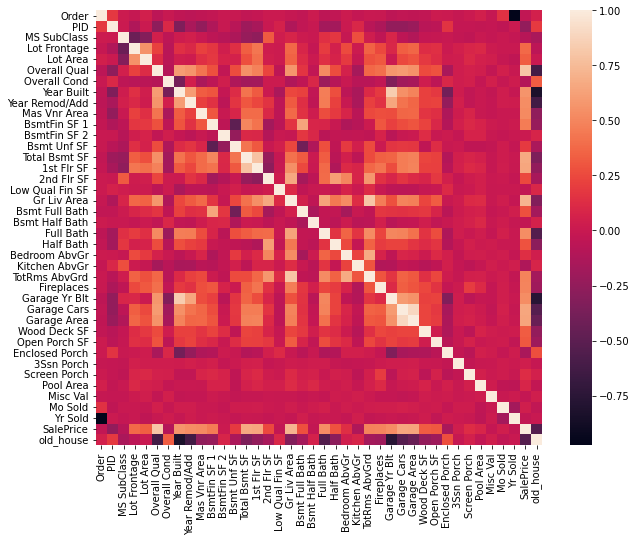

In [ ]:
""" To check probably not necessary """
import seaborn as sns
corr_matrix = train_df.corr()


plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
plt.show()


In [ ]:
""" Checking collinearity """
""" To check probably not necessary """
features = train_df.drop(["SalePrice","1st Flr SF", "Total Bsmt SF"], axis=1).select_dtypes(include="number").columns

# Create input matrix with the additional column of ones
X = train_df[features].values
X1 = np.c_[np.ones(X.shape[0]), X]
# Compute rank and condition number
M = X1.shape[1]  # Number of columns
rank = np.linalg.matrix_rank(X1)
cond = np.linalg.cond(X1)
print("Columns {} rank {} collinear {}".format(M, rank, M - rank))
print("Condition number:", cond)
""" Condition number: too big! """

Columns 34 rank 34 collinear 0
Condition number: 18651904.069875337


' Condition number: too big! '

In [ ]:
""" Trying to find the collinear features to remove. It's not working very well """
def find_collinear_features(df):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    return to_drop

to_drop = find_collinear_features(train_df)
print(to_drop)
""" train_df = train_df.drop(to_drop, axis=1) """

['TotRms AbvGrd', 'Garage Area', 'SalePrice']


' train_df = train_df.drop(to_drop, axis=1) '

To identify incorrect and missing values in your data
---

Check for missing values: Look for missing values in the dataset and determine if they are missing at random or if they have a pattern. If they have a pattern, you can use imputation methods to fill in the missing values. If they are missing at random, you can simply delete the rows with missing values.

Check for inconsistencies: Check for inconsistencies in the data by comparing values for the same observation across different columns. For example, you may have a column for the year a house was built and another for the year it was sold. If the year of sale is before the year of construction, you know there is an error.

Check for outliers: Look for outliers in the dataset by plotting histograms, box plots or scatter plots. Outliers can have a big impact on your model's predictions, so you may want to remove them, replace them with the median or average value, or try to understand why they exist.

Check for incorrect data types: Make sure each column in the dataset has the correct data type. For example, if a column is supposed to contain only numerical values, make sure it doesn't contain any strings or other non-numerical values.

Check for duplicates: Look for duplicate rows in the dataset and remove them if necessary.

### Feature engineering
Your analysis should also include feature engineering. Here are a few ideas

- Create indicator variables ex. year of construction is older than some threshold
- Transformations ex. log-transforms, polynomials

Suggestion: write down your feature engineering ideas during the data exploration stage.


Suggestion:
---

- Creating a new binary or categorical variable that indicates the presence or absence of some characteristic. For example, creating a binary indicator for houses that are older than a certain age.

- Transforming the original features to create new, potentially more informative features. Common transformations include log-transforms, polynomials, square roots, and reciprocals. These can help improve the linearity of the relationship between the features and the target variable, making it easier for a model to learn the relationship.

- Grouping continuous variables into a smaller number of categories. This can help reduce the impact of outliers and improve the interpretability of the model.

- Creating new features that are the product or sum of two or more original features. Interactions can capture non-linear relationships between features and target variables, which might be missed by a linear model.

In [ ]:
""" To check probably not necessary """
# Create dummy variable to represent is a house old or not
threshold = train_df["Year Built"].median()
train_df["old_house"] = (train_df["Year Built"] < threshold).astype(int)

# Drop "Year Built"
tarin_df = train_df.drop("Year Built", axis=1)


The above code creates a new column ``"old_house"`` in the DataFrame, with the values 0 or 1, depending on whether the year of construction in the ``"Year Built"`` column is older or not older than the threshold. The ``astype(int)`` method is used to convert the values to integers.

# Plot all the data

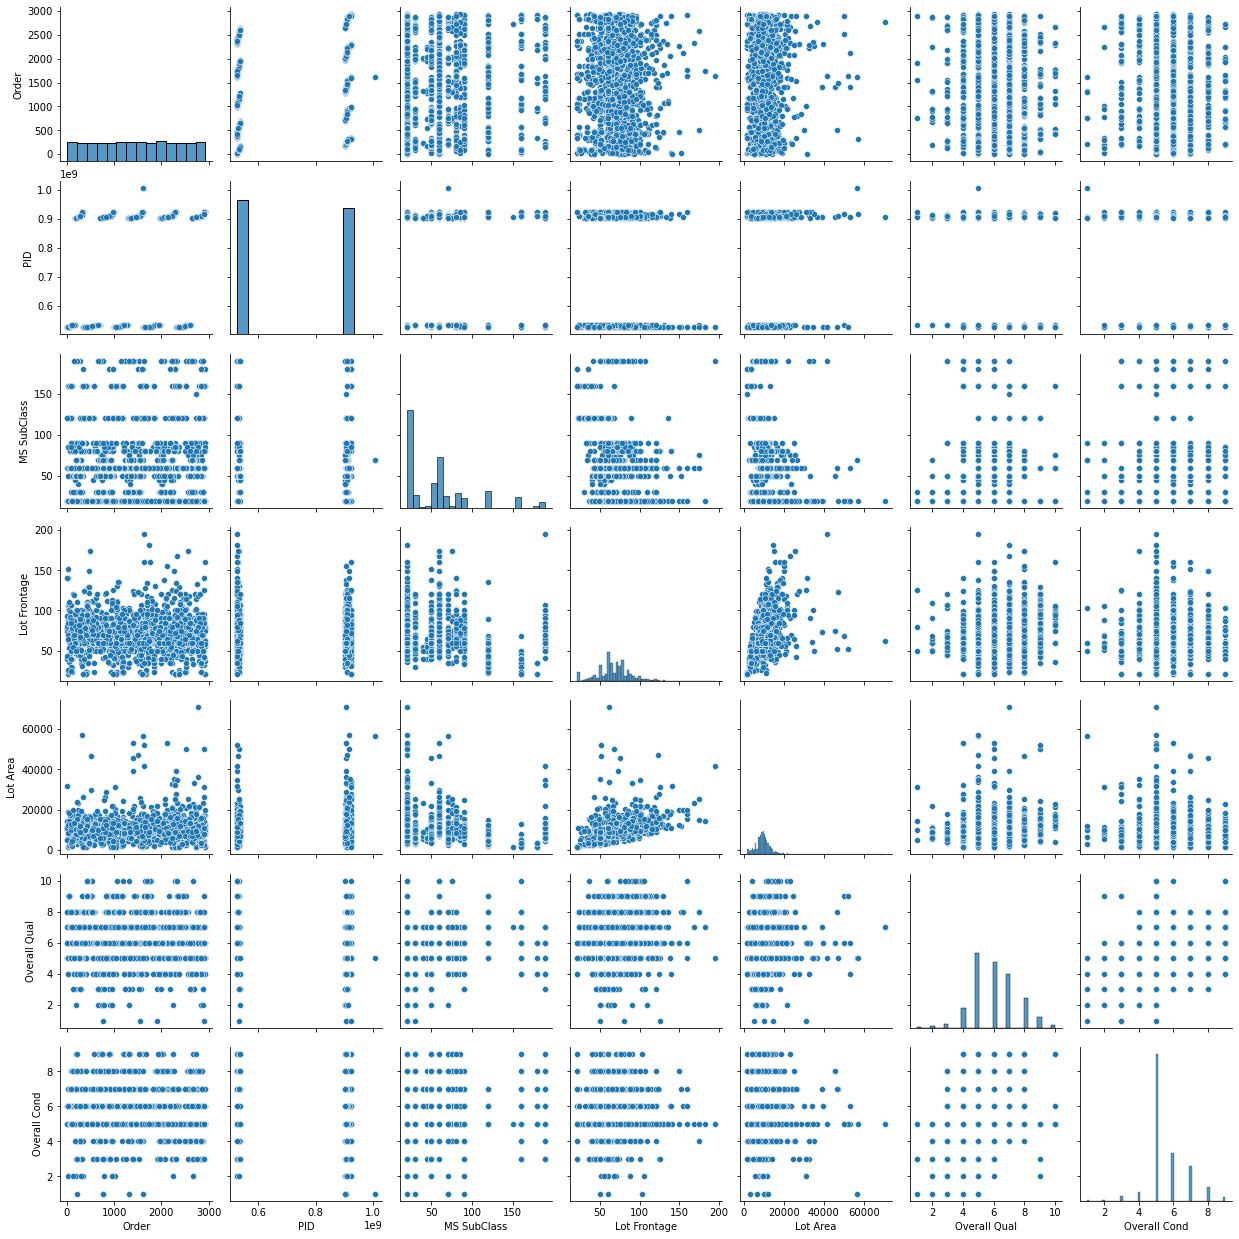

In [ ]:
(train_df.iloc[:, :20]);

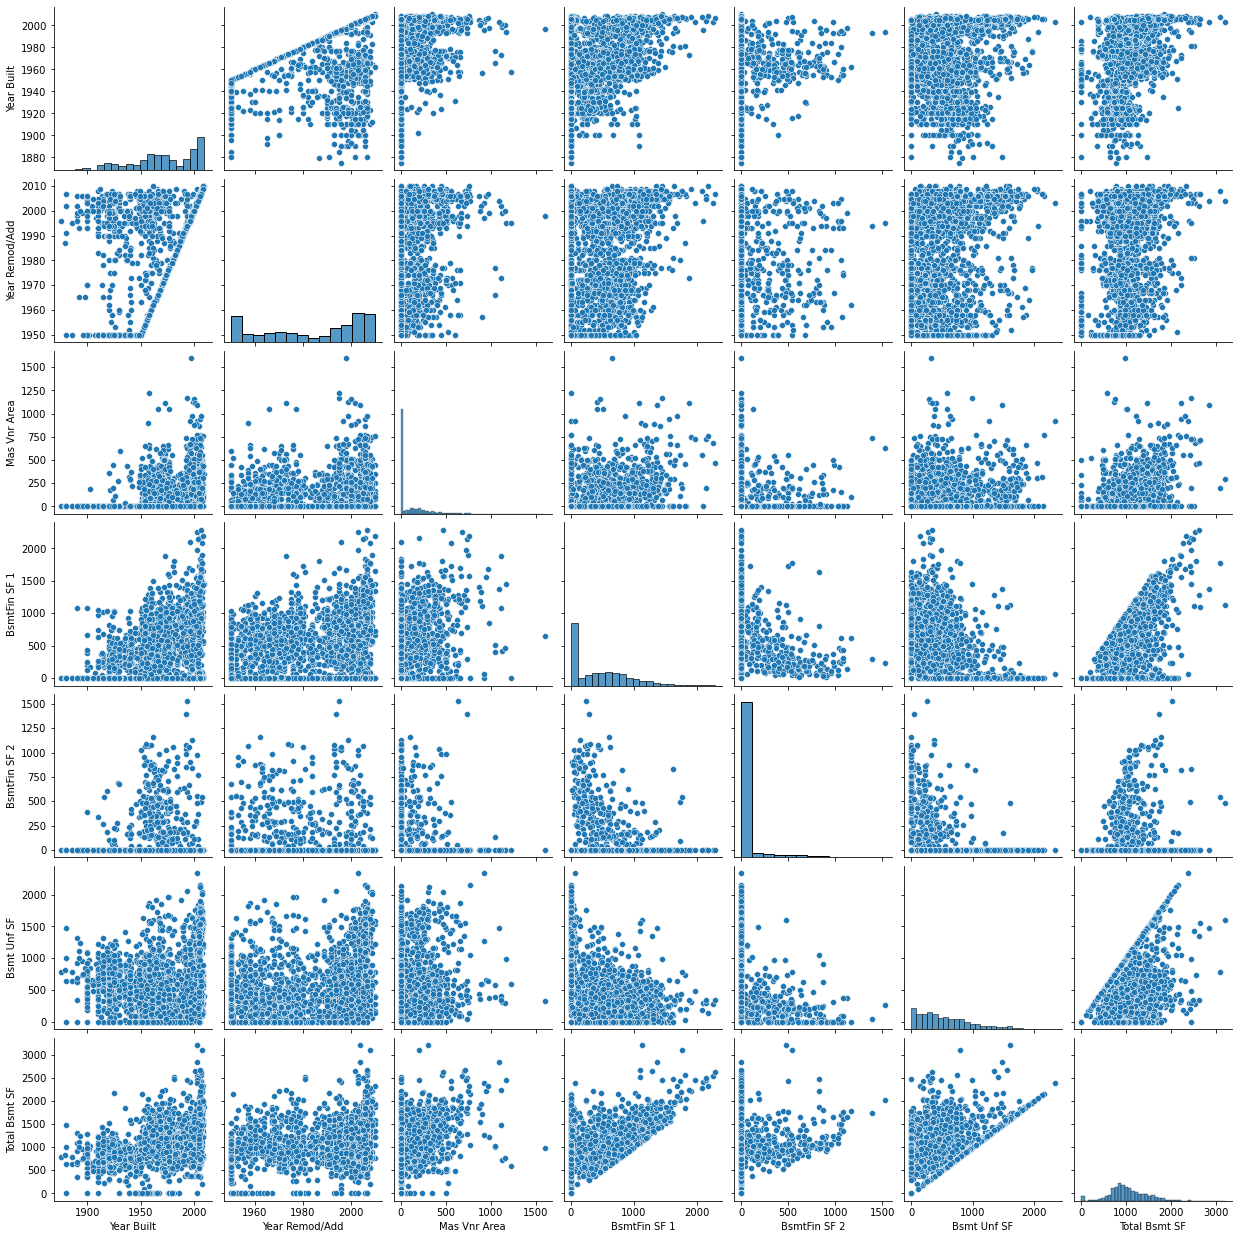

In [ ]:
sns.pairplot(train_df.iloc[:, 20:40]);

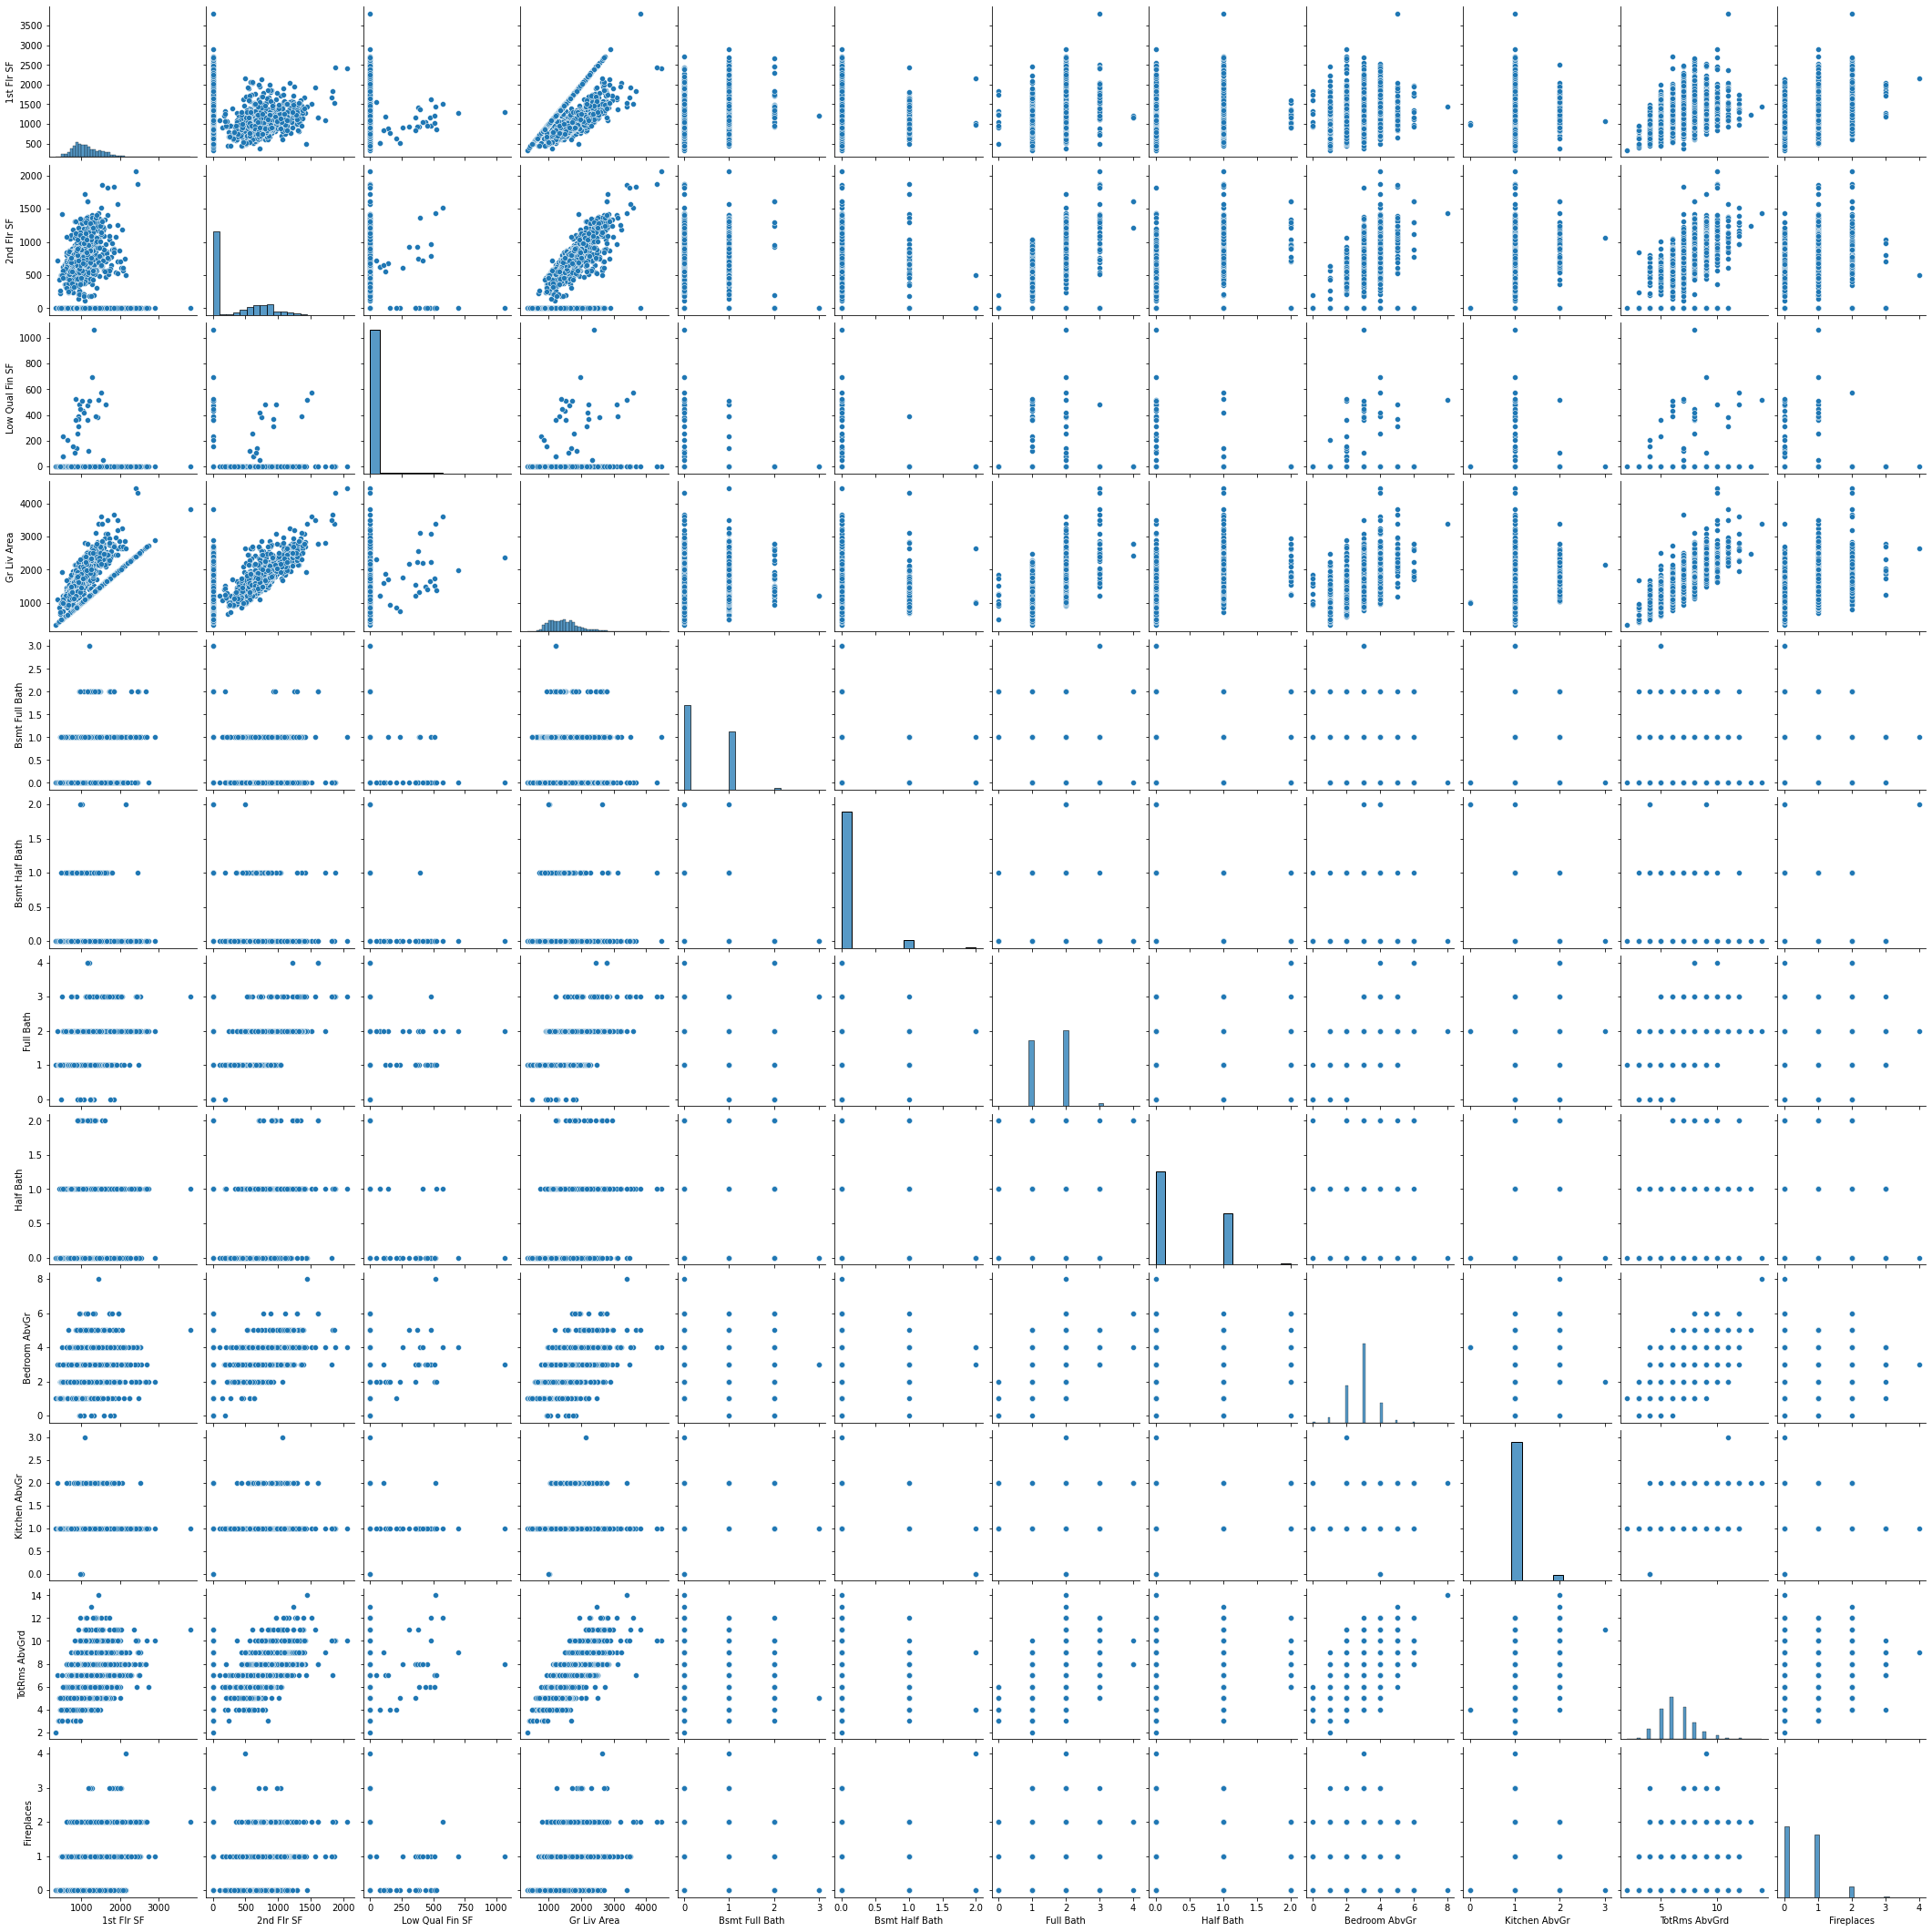

In [ ]:
sns.pairplot(train_df.iloc[:, 40:60]);

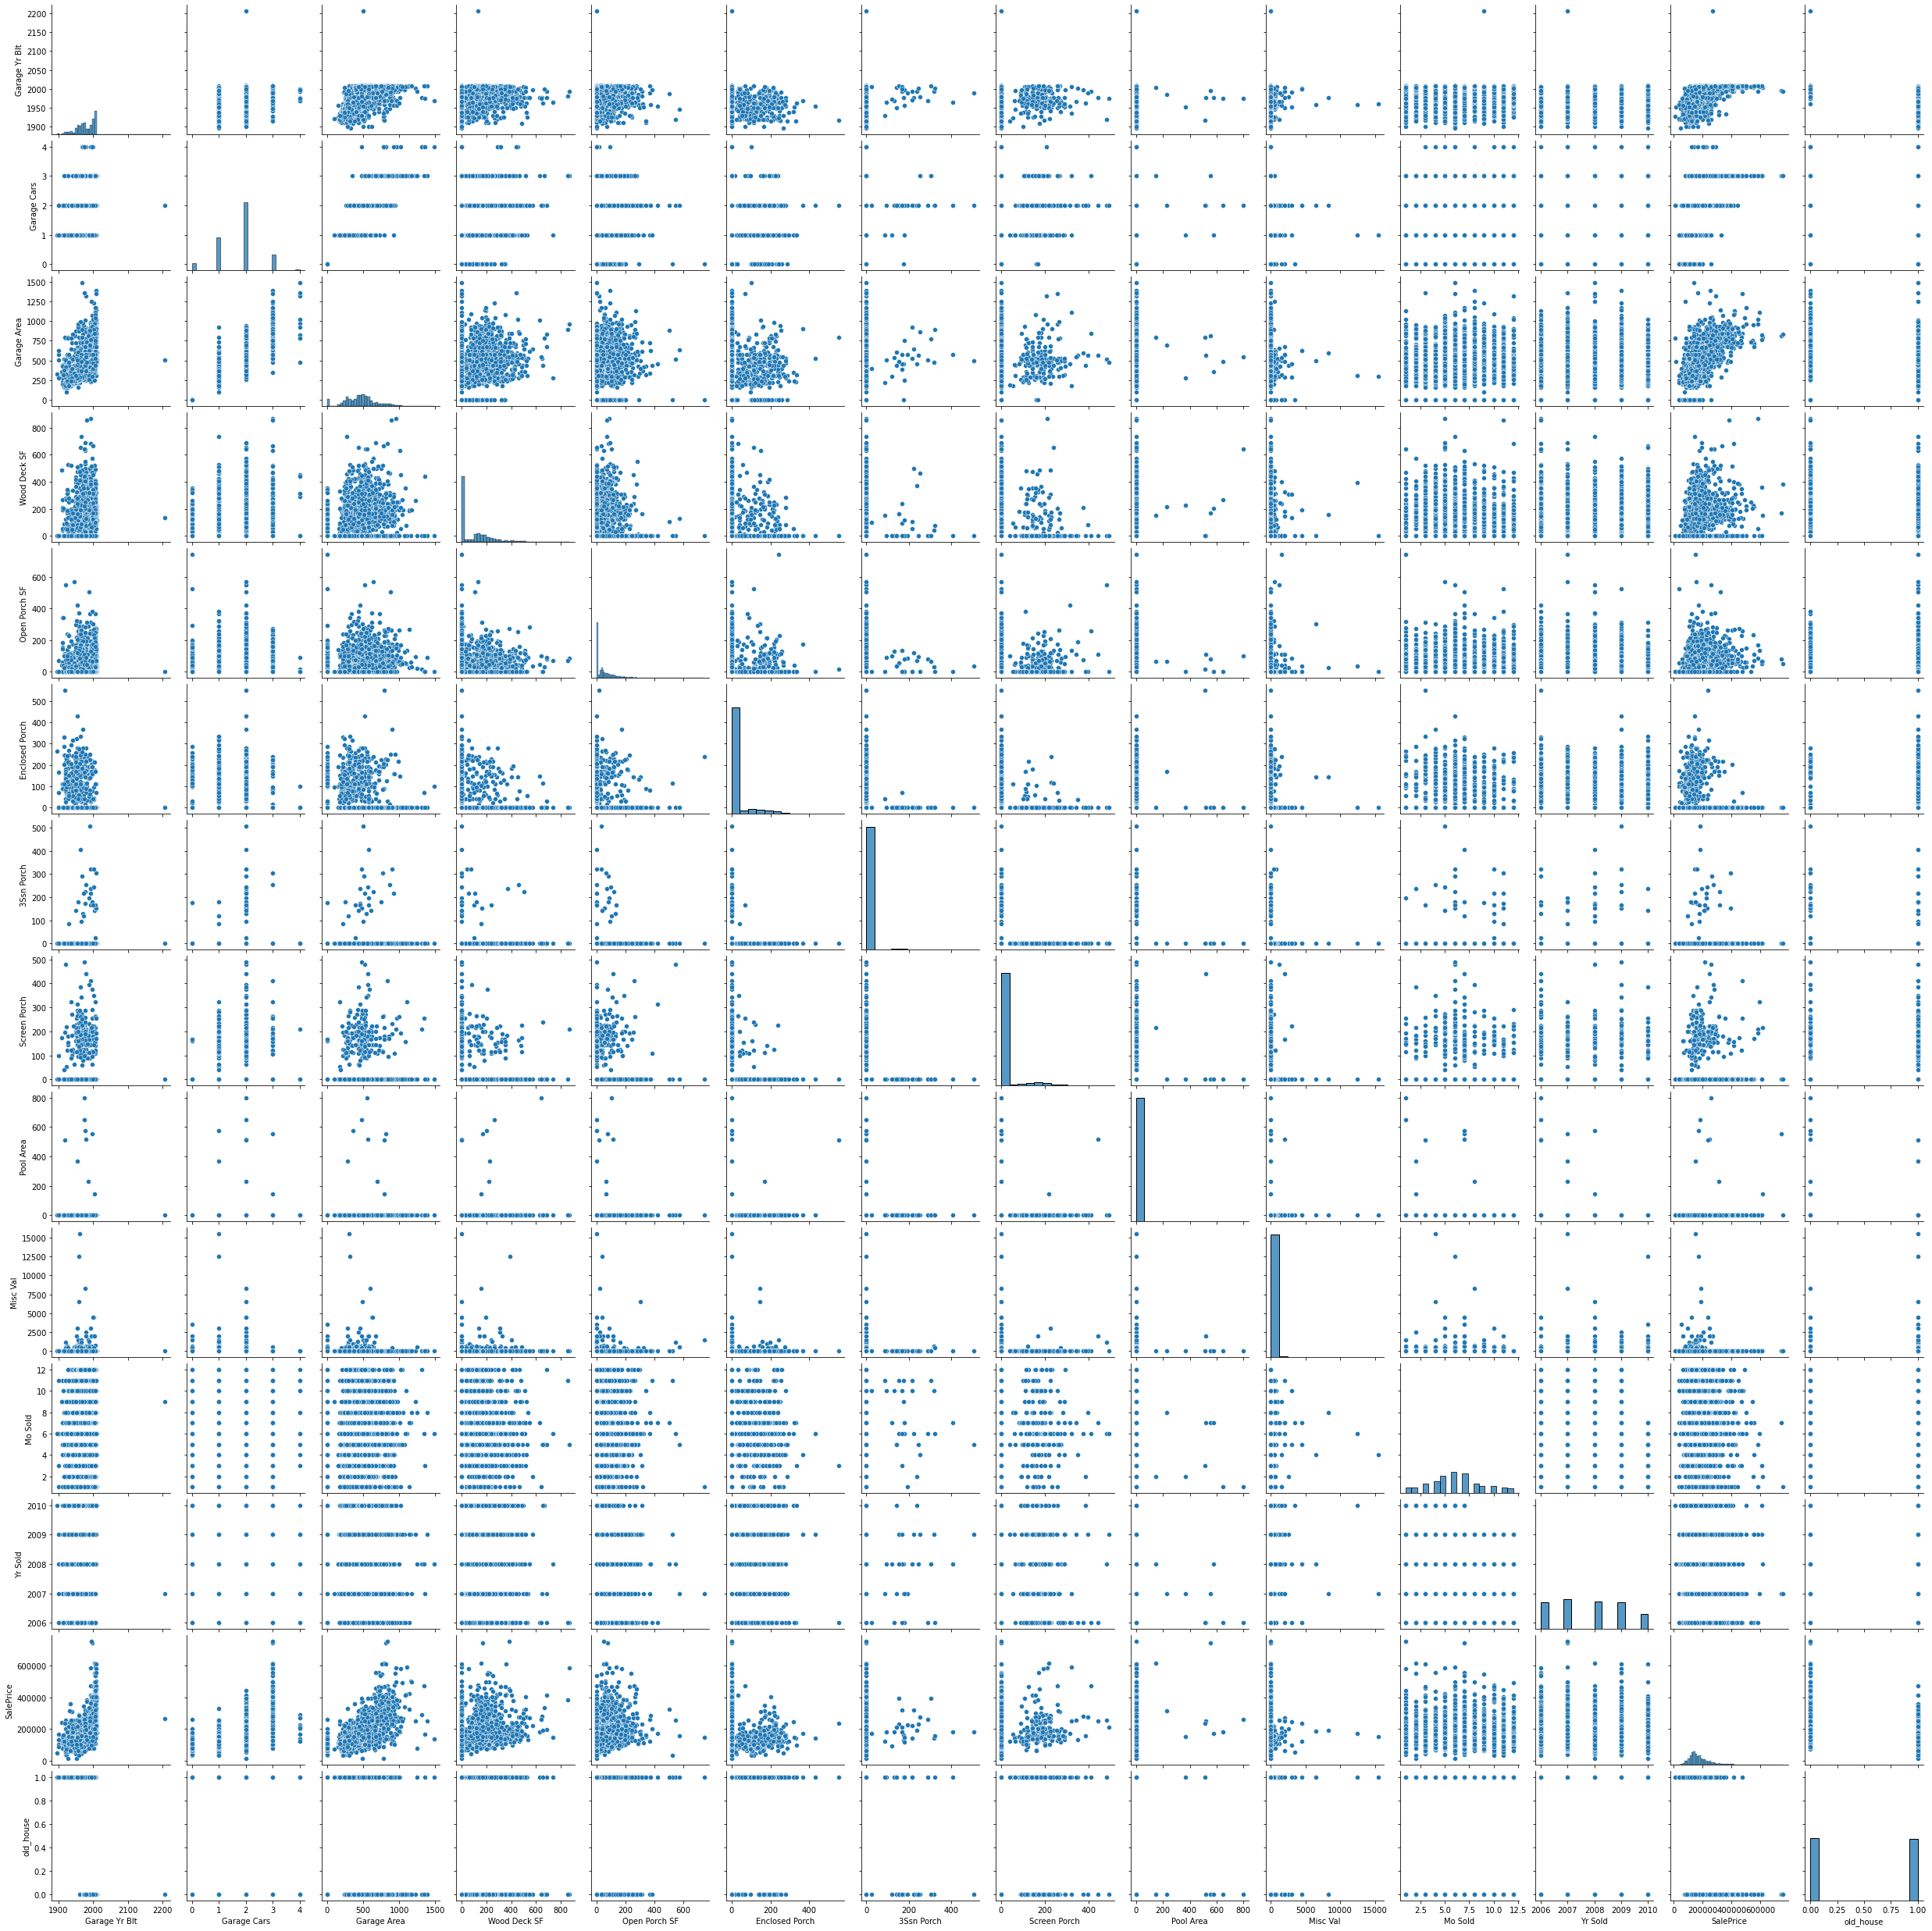

In [ ]:
sns.pairplot(train_df.iloc[:, 60:]);

### Feature encoding
Your analysis should include the necessary feature encoding steps. The documentation.txt file labels each variable with its type. For categorical ones, it uses the ordinal and nominal classification.

- Ordinal variables - you can order the categories
- Nominal variables - no possible ordering of the categories

The encoding depends on the type of variable and its meaning. For instance, the kitchen quality variable is on a scale from excellent to poor. Hence, it’s an ordinal variable, and you can choose to apply one-hot encoding or define a numerical scale ex. excellent corresponds to 5 and poor to 1. In any case, justify your choices!

# to read 
Encoding categorical variables is an important step in the data preprocessing pipeline.

For ordinal variables, you can encode the categories as numerical values that reflect the order of the categories. For example, if the kitchen quality variable has the categories "excellent", "good", "average", "fair", and "poor", you can assign numerical values to them such as 5 for "excellent", 4 for "good", 3 for "average", 2 for "fair", and 1 for "poor". This way, the encoding captures the ordinal relationship between the categories.

For nominal variables, there is no meaningful order between the categories. In this case, one-hot encoding is a common choice. One-hot encoding creates a binary column for each category and assigns a 1 or 0 to the columns based on the category of the original variable. For example, if the nominal variable has three categories "A", "B", and "C", the one-hot encoding would create three new binary columns "A", "B", and "C".

When choosing the encoding method, it's important to consider the meaning of the variable and the type of model you'll be using. For example, one-hot encoding is appropriate for nominal variables and decision tree-based models, but it can lead to sparse data and a large number of features for linear models. In such cases, a different encoding method like target encoding or ordinal encoding may be more suitable.

In summary, the choice of encoding method depends on the type of variable and its meaning, as well as the type of model you'll be using. Justifying your choices is important to ensure that your encoding is meaningful and suitable for your analysis.

In [ ]:
# One-hot encode
train_df = pd.get_dummies(train_df, drop_first=True)

Splitting data
---
You should split the data into training and validation sets (e.g. 60-40 split). You will use the training set for fitting the models and the validation set for evaluating the models and tuning hyperparameters.

In [ ]:
X = train_df.drop("SalePrice", axis=1)
y = train_df.SalePrice

# Spliting data
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.4, random_state=0)


# Compute baseline
baseline = y_val - np.median(y_val) 
""" Not sure of the formula to check!!!!! """


' Not sure of the formula to check!!!!! '

In [ ]:
""" to remove """
X_tr.iloc[:, :20]

Lot Frontage  Lot Area  Overall Qual  Overall Cond  Year Built  \
1496          50.0      7030             4             6        1925   
2192           0.0     11885             8             5        2001   
1952          21.0      1526             4             8        1970   
414           60.0      6324             4             6        1927   
2251           0.0     14585             6             6        1960   
...            ...       ...           ...           ...         ...   
1037          81.0     14267             6             6        1958   
1738         119.0     10895             5             6        1955   
766            0.0      4538             9             5        2001   
838          114.0     17242             9             5        1993   
1660          60.0     11340             2             1        1920   

      Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  \
1496            1950           0.0           0.0           0.0        641.0   
2192            2001         108.0         990.0           0.0        309.0   
1952            2002           0.0         515.0           0.0        115.0   
414             1950           0.0           0.0           0.0        520.0   
2251            1987          85.0         594.0         219.0        331.0   
...              ...           ...           ...           ...          ...   
1037            1958         108.0         923.0           0.0        406.0   
1738            1955           0.0         648.0           0.0        324.0   
766             2001         179.0        1004.0           0.0        306.0   
838             1994         738.0         292.0        1393.0         48.0   
1660            1950           0.0           0.0           0.0        723.0   

      Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
1496          641.0         641           0                0          641   
2192         1299.0        1299         573                0         1872   
1952          630.0         630           0                0          630   
414           520.0         520           0                0          520   
2251         1144.0        1429           0                0         1429   
...             ...         ...         ...              ...          ...   
1037         1329.0        1329           0                0         1329   
1738          972.0         972           0                0          972   
766          1310.0        1310           0                0         1310   
838          1733.0        1933        1567                0         3500   
1660          723.0         723         363                0         1086   

      Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  
1496             0.0             0.0          1          0              2  
2192             1.0             0.0          2          1              3  
1952             1.0             0.0          1          0              1  
414              0.0             0.0          1          0              1  
2251             0.0             1.0          1          0              3  
...              ...             ...        ...        ...            ...  
1037             0.0             0.0          1          1              3  
1738             0.0             0.0          1          0              3  
766              1.0             0.0          1          1              1  
838              1.0             0.0          3          1              4  
1660             0.0             0.0          1          0              2  

[1452 rows x 20 columns]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Setup each regression
pipe_lr =  Pipeline([("scaler",StandardScaler()), ("lr", LinearRegression())])
ridge = Pipeline([("scaler",StandardScaler()), ("ridge", LinearRegression())])
pipe_lr2 = Pipeline([("scaler",StandardScaler()), ("coef", PolynomialFeatures()), ("lr", LinearRegression())])

# Fit 
pipe_lr.fit(X_tr, y_tr)
# taking a simple of first 20 features
ridge.fit(X_tr.iloc[:, :20], y_tr)
pipe_lr2.fit(X_tr, y_tr)

# Display the results
print("MAE for linear regression without ouliers: {:.3f}".format(MAE(y_val, pipe_lr.predict(X_val))))
print("MAE for Ridge regression without ouliers: {:.3f}".format(MAE(y_val, ridge.predict(X_val.iloc[:, :20]))))
print("MAE for linear regression with ouliers: {:.3f}".format(MAE(y_val, pipe_lr2.predict(X_val))))

MAE for linear regression without ouliers: 101972840032807.125
MAE for Ridge regression without ouliers: 20290.485
MAE for linear regression with ouliers: 23940.863


In [ ]:
# check code for random selection

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

# check code below

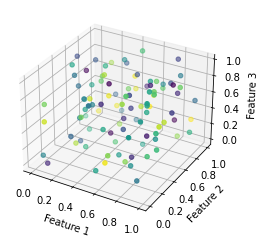

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Generate random data
X = np.random.rand(100, 3)
y = np.random.rand(100)

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()